# Overview

・コロナウイルスに関するオープンデータを活用して、1日ごとの感染者数を時系列予測する

# Module

In [1]:
!pip install keras==2.3.1

     |████████████████████████████████| 377 kB 285 kB/s 
     |████████████████████████████████| 50 kB 2.8 MB/s 


In [2]:
pip install tensorflow==1.4

ERROR: Could not find a version that satisfies the requirement tensorflow==1.4 (from versions: 1.13.0rc1, 1.13.0rc2, 1.13.1, 1.13.2, 1.14.0rc0, 1.14.0rc1, 1.14.0, 1.15.0rc0, 1.15.0rc1, 1.15.0rc2, 1.15.0rc3, 1.15.0, 1.15.2, 1.15.3, 1.15.4, 1.15.5, 2.0.0a0, 2.0.0b0, 2.0.0b1, 2.0.0rc0, 2.0.0rc1, 2.0.0rc2, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.1.0rc0, 2.1.0rc1, 2.1.0rc2, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.2.0rc0, 2.2.0rc1, 2.2.0rc2, 2.2.0rc3, 2.2.0rc4, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.3.0rc0, 2.3.0rc1, 2.3.0rc2, 2.3.0, 2.3.1, 2.3.2, 2.3.3, 2.3.4, 2.4.0rc0, 2.4.0rc1, 2.4.0rc2, 2.4.0rc3, 2.4.0rc4, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.5.0rc0, 2.5.0rc1, 2.5.0rc2, 2.5.0rc3, 2.5.0, 2.5.1, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0, 2.7.0rc0, 2.7.0rc1)
ERROR: No matching distribution found for tensorflow==1.4
Note: you may need to restart the kernel to use updated packages.


In [3]:
import re
import json
import math
import optuna
import numpy as np
import pandas as pd
import seaborn as sns 
import lightgbm as lgb
import statsmodels.api as sm
import matplotlib.pyplot as plt

from pandas import json_normalize
from sklearn.linear_model import Ridge
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

2021-10-26 08:01:04.335238: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-10-26 08:01:04.335366: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Datasets

・NHK コロナウイルス データ（全国）：https://www3.nhk.or.jp/news/special/coronavirus/data-widget/

In [4]:
df = pd.read_csv('../input/d/yshiml/covid19/nhk_news_covid19_prefectures_daily_data.csv')
df = df.rename(columns={'日付': 'date',
                        '都道府県名': 'prefecture',
                        '各地の感染者数_1日ごとの発表数': 'infection_day',
                        '各地の感染者数_累計': 'infection_sum',
                        '各地の死者数_1日ごとの発表数': 'deaths_day',
                        '各地の死者数_累計': 'deaths_sum'})
df['deaths_day'] = df['deaths_day'].astype(float)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d').dt.date
df = df.drop(['都道府県コード', '各地の直近1週間の人口10万人あたりの感染者数'], axis=1)

print(df.shape)
print(df.dtypes)
df.head(10)

(29845, 6)
date              object
prefecture        object
infection_day      int64
infection_sum      int64
deaths_day       float64
deaths_sum         int64
dtype: object


,date,prefecture,infection_day,infection_sum,deaths_day,deaths_sum
0,2020-01-16,北海道,0,0,0.0,0
1,2020-01-17,北海道,0,0,0.0,0
2,2020-01-18,北海道,0,0,0.0,0
3,2020-01-19,北海道,0,0,0.0,0
4,2020-01-20,北海道,0,0,0.0,0
5,2020-01-21,北海道,0,0,0.0,0
6,2020-01-22,北海道,0,0,0.0,0
7,2020-01-23,北海道,0,0,0.0,0
8,2020-01-24,北海道,0,0,0.0,0
9,2020-01-25,北海道,0,0,0.0,0


In [5]:
pd.DataFrame([['infection_day', '1日ごとの感染者数'],
              ['infection_sum', '累積感染者数'],
              ['deaths_day', '1日ごとの死亡者数'],
              ['deaths_sum', '累積死亡者数']],
              columns=['カラム', '意味'])

,カラム,意味
0,infection_day,1日ごとの感染者数
1,infection_sum,累積感染者数
2,deaths_day,1日ごとの死亡者数
3,deaths_sum,累積死亡者数


・内閣官房 コロナウイルス 人流の増減率データ（全国）：https://corona.go.jp/dashboard/

In [6]:
filename = '../input/d/yshiml/covid19/ReductionRate.json'

fd = open(filename, mode='r')
data = json.load(fd)
fd.close()

In [7]:
df2 = json_normalize(data['itemList'])
df2['comparisonPreDeclare'] = df2['comparisonPreDeclare'].astype(float)
df2['comparisonPreSpread'] = df2['comparisonPreSpread'].astype(float)
df2['comparisonPreDay'] = df2['comparisonPreDay'].astype(float)
df2['date'] = pd.to_datetime(df2['date'], format='%Y-%m-%d').dt.date
df2 = df2.rename(columns={'dataName': 'prefecture'})
df2 = df2.drop('dataType', axis=1)

print(df2.shape)
print(df2.dtypes)
df2.tail(10)

(24874, 5)
date                     object
prefecture               object
comparisonPreDay        float64
comparisonPreDeclare    float64
comparisonPreSpread     float64
dtype: object


,date,prefecture,comparisonPreDay,comparisonPreDeclare,comparisonPreSpread
24864,2020-05-12,高知県はりまや橋周辺,2.7,-7.4,-22.4
24865,2020-05-12,福岡県天神周辺,-2.8,-38.7,-55.2
24866,2020-05-12,福岡県天神周辺,-2.8,-38.7,-55.2
24867,2020-05-12,佐賀県佐賀駅周辺,-4.1,-10.2,-17.8
24868,2020-05-12,長崎県長崎駅周辺,1.3,-16.9,-39.0
24869,2020-05-12,熊本県通町筋周辺,-6.5,-11.5,-30.7
24870,2020-05-12,大分県大分駅付近周辺,0.2,-13.1,-34.1
24871,2020-05-12,宮崎県新別府町周辺,8.2,-29.5,-44.0
24872,2020-05-12,鹿児島県天文館周辺,-0.3,-10.9,-22.9
24873,2020-05-12,沖縄県県庁前周辺,-6.9,-26.1,-26.6


In [8]:
pd.DataFrame([['comparisonPreDay', '全国の人流増減率（対前日比）'],
              ['comparisonPreDeclare', '全国の人流増減率（対緊急事態宣言前比）'],
              ['comparisonPreSpread', '全国の人流増減率（対感染拡大前比）']],
              columns=['カラム', '意味'])

,カラム,意味
0,comparisonPreDay,全国の人流増減率（対前日比）
1,comparisonPreDeclare,全国の人流増減率（対緊急事態宣言前比）
2,comparisonPreSpread,全国の人流増減率（対感染拡大前比）


・厚生労働省 PCR検査実施人数（全国）：https://www.mhlw.go.jp/stf/covid-19/open-data.html

In [9]:
df3 = pd.read_csv('../input/d/yshiml/covid19/pcr_tested_daily.csv')
df3 = df3.rename(columns={'日付': 'date', 'PCR 検査実施件数(単日)': 'pcr_person'})
df3['date'] = pd.to_datetime(df3['date'], format='%Y-%m-%d').dt.date

print(df3.shape)
print(df3.dtypes)
df3.head(10)

(614, 2)
date           object
pcr_person    float64
dtype: object


,date,pcr_person
0,2020-02-05,4.0
1,2020-02-06,19.0
2,2020-02-07,9.0
3,2020-02-08,4.0
4,2020-02-09,10.0
5,2020-02-10,12.0
6,2020-02-11,4.0
7,2020-02-12,10.0
8,2020-02-13,16.0
9,2020-02-14,43.0


In [10]:
pd.DataFrame([['pcr_person', 'PCR検査の実施人数']],columns=['カラム', '意味'])

,カラム,意味
0,pcr_person,PCR検査の実施人数


・厚生労働省 PCR検査実施件数（全国）：https://www.mhlw.go.jp/stf/covid-19/open-data.html

In [11]:
df4 = pd.read_csv('../input/d/yshiml/covid19/pcr_case_daily.csv')
df4 = df4.rename(columns={'日付': 'date', '計': 'pcr_case'})
df4 = df4[['date', 'pcr_case']]
df4['date'] = pd.to_datetime(df4['date'], format='%Y-%m-%d').dt.date

print(df4.shape)
print(df4.dtypes)
df4.head(10)

(598, 2)
date        object
pcr_case     int64
dtype: object


,date,pcr_case
0,2020-02-18,1024
1,2020-02-19,692
2,2020-02-20,793
3,2020-02-21,1591
4,2020-02-22,1166
5,2020-02-23,654
6,2020-02-24,602
7,2020-02-25,928
8,2020-02-26,1405
9,2020-02-27,1399


In [12]:
pd.DataFrame([['pcr_case', 'PCR検査の実施件数']],columns=['カラム', '意味'])

,カラム,意味
0,pcr_case,PCR検査の実施件数


# Preprocess

In [13]:
df2.head(10)

,date,prefecture,comparisonPreDay,comparisonPreDeclare,comparisonPreSpread
0,2021-10-10,北海道札幌駅周辺,-5.4,1.9,7.7
1,2021-10-10,青森県青森駅周辺,-10.9,-29.3,-28.0
2,2021-10-10,岩手県盛岡駅北周辺,-14.1,-8.4,-28.6
3,2021-10-10,宮城県仙台駅西周辺,-6.5,3.0,-10.3
4,2021-10-10,秋田県秋田駅周辺,-12.4,-15.5,-21.4
5,2021-10-10,山形県山形駅周辺,-12.1,-15.5,-25.8
6,2021-10-10,福島県福島駅周辺,-0.7,16.3,-10.8
7,2021-10-10,茨城県水戸駅周辺,-11.7,-12.6,-20.0
8,2021-10-10,栃木県宇都宮駅周辺,-9.9,27.2,-16.3
9,2021-10-10,群馬県高崎駅西周辺,0.4,32.3,-7.1


・正規表現を用いて、prefectureの情報を簡潔にする

In [14]:
def processor(text):
    text = re.sub('<br>', '', text)
    text = re.sub('周辺', '', text)
    text = re.sub('都...', '都', text)
    text = re.sub('北海道...', '北海道', text)
    text = re.sub('府...', '府', text)
    text = re.sub('府.', '府', text)
    text = re.sub('府.', '府', text)
    text = re.sub('県....', '県', text)
    text = re.sub('県...', '県', text)
    text = re.sub('県.', '県', text)
    text = re.sub('県.', '県', text)
    text = re.sub('県.', '県', text)
    return text

In [15]:
df2['prefecture'] = df2['prefecture'].apply(lambda x: processor(x))
df2.head(10)

,date,prefecture,comparisonPreDay,comparisonPreDeclare,comparisonPreSpread
0,2021-10-10,北海道,-5.4,1.9,7.7
1,2021-10-10,青森県,-10.9,-29.3,-28.0
2,2021-10-10,岩手県,-14.1,-8.4,-28.6
3,2021-10-10,宮城県,-6.5,3.0,-10.3
4,2021-10-10,秋田県,-12.4,-15.5,-21.4
5,2021-10-10,山形県,-12.1,-15.5,-25.8
6,2021-10-10,福島県,-0.7,16.3,-10.8
7,2021-10-10,茨城県,-11.7,-12.6,-20.0
8,2021-10-10,栃木県,-9.9,27.2,-16.3
9,2021-10-10,群馬県,0.4,32.3,-7.1


# Visualization

・dfについての相関関係を確認する

<AxesSubplot:>

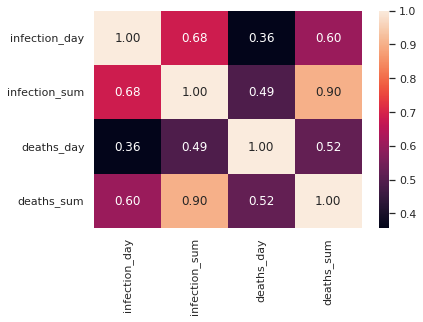

In [16]:
sns.set()
sns.heatmap(df.corr(), annot=True, fmt='.2f')

・全国の1日ごとの感染者数

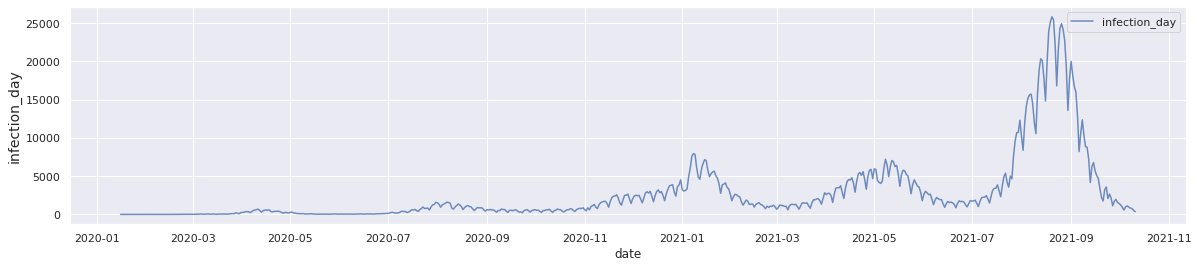

In [17]:
fig, axes = plt.subplots(figsize=(20, 4))
df.groupby('date').agg({'infection_day': 'sum'}).plot(ax=axes, label='date', alpha=0.8).set_ylabel('infection_day', fontsize=14)
axes.legend()

・全国の累積感染者数

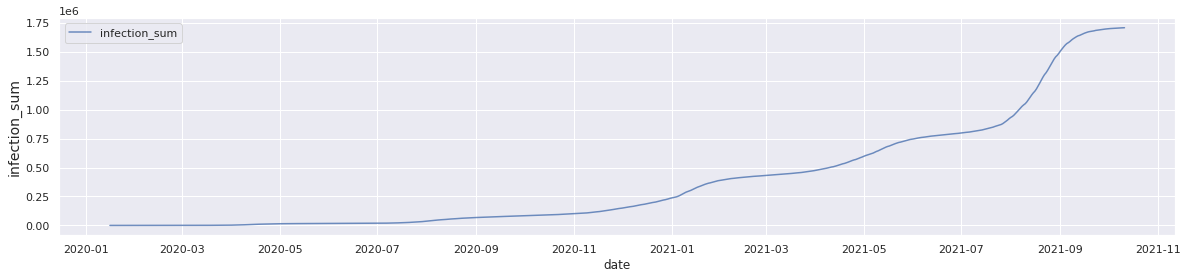

In [18]:
fig, axes = plt.subplots(figsize=(20, 4))
df.groupby('date').agg({'infection_sum': 'sum'}).plot(ax=axes, label='date', alpha=0.8).set_ylabel('infection_sum', fontsize=14)
axes.legend()

・全国の1日ごとの死亡者数

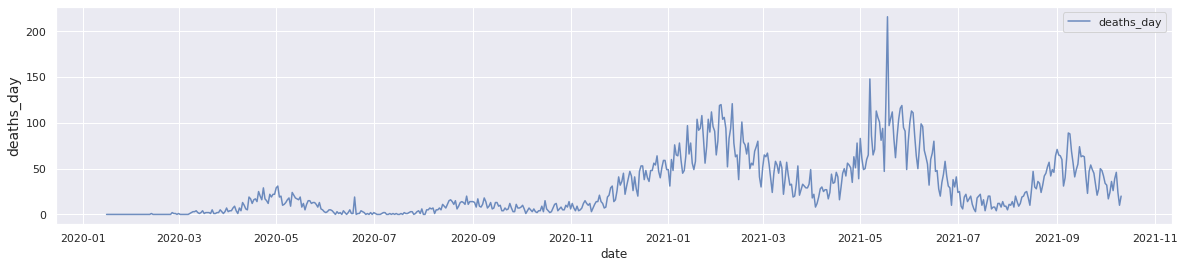

In [19]:
fig, axes = plt.subplots(figsize=(20, 4))
df.groupby('date').agg({'deaths_day': 'sum'}).plot(ax=axes, label='date', alpha=0.8).set_ylabel('deaths_day', fontsize=14)
axes.legend()

・全国の累積死亡者数

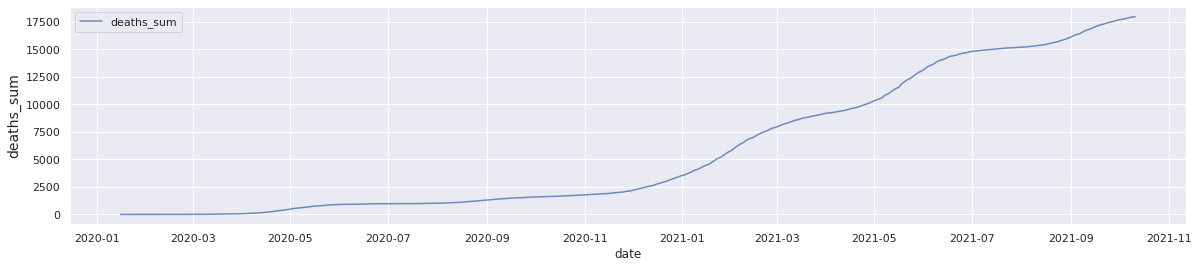

In [20]:
fig, axes = plt.subplots(figsize=(20, 4))
df.groupby('date').agg({'deaths_sum': 'sum'}).plot(ax=axes, label='date', alpha=0.8).set_ylabel('deaths_sum', fontsize=14)
axes.legend()

・df2についての相関関係を確認する

<AxesSubplot:>

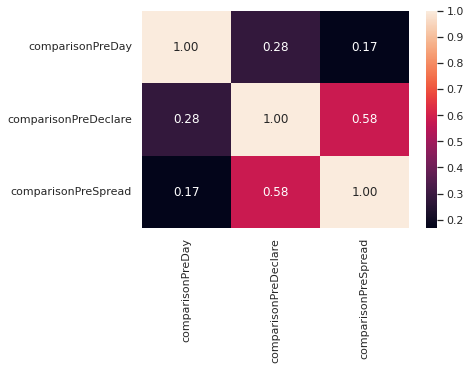

In [21]:
sns.set()
sns.heatmap(df2.corr(), annot=True, fmt='.2f')

・全国の人流増減率（対前日比）

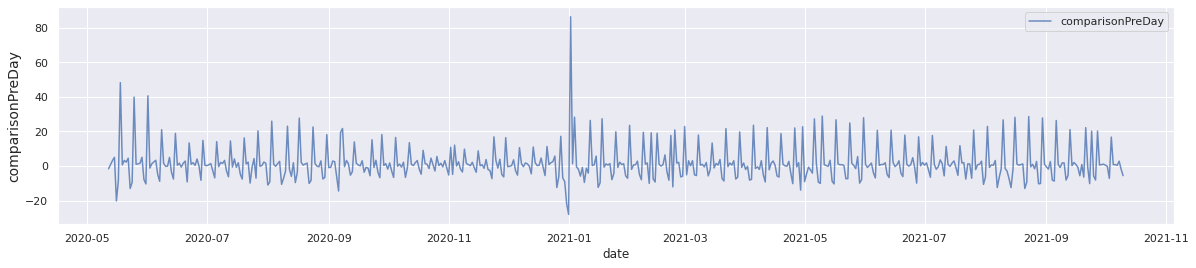

In [22]:
fig, axes = plt.subplots(figsize=(20, 4))
df2.groupby('date').agg({'comparisonPreDay': 'mean'}).plot(ax=axes, label='date', alpha=0.8).set_ylabel('comparisonPreDay', fontsize=14)
axes.legend()

・全国の人流増減率（対緊急事態宣言前比）

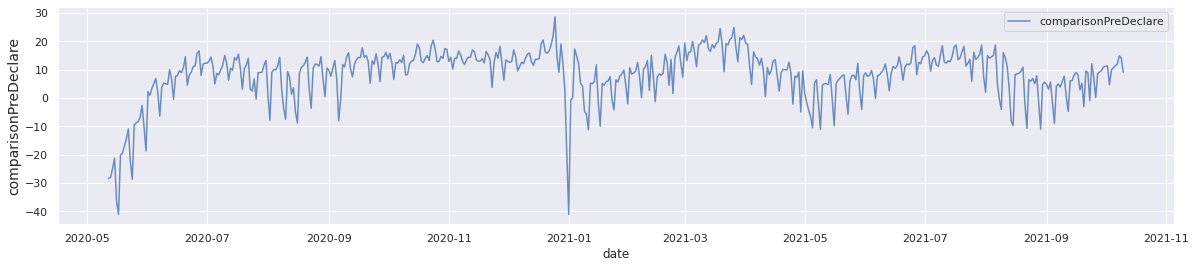

In [23]:
fig, axes = plt.subplots(figsize=(20, 4))
df2.groupby('date').agg({'comparisonPreDeclare': 'mean'}).plot(ax=axes, label='date', alpha=0.8).set_ylabel('comparisonPreDeclare', fontsize=14)
axes.legend()

・全国の人流増減率（対感染拡大前比）

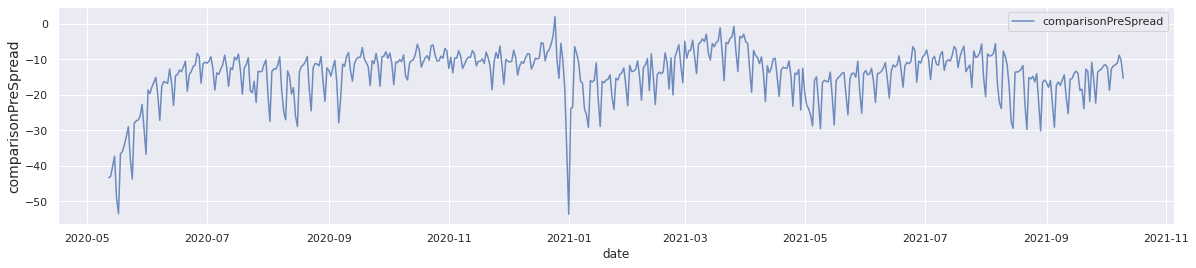

In [24]:
fig, axes = plt.subplots(figsize=(20, 4))
df2.groupby('date').agg({'comparisonPreSpread': 'mean'}).plot(ax=axes, label='date', alpha=0.8).set_ylabel('comparisonPreSpread', fontsize=14)
axes.legend()

・全国のPCR検査の実施人数

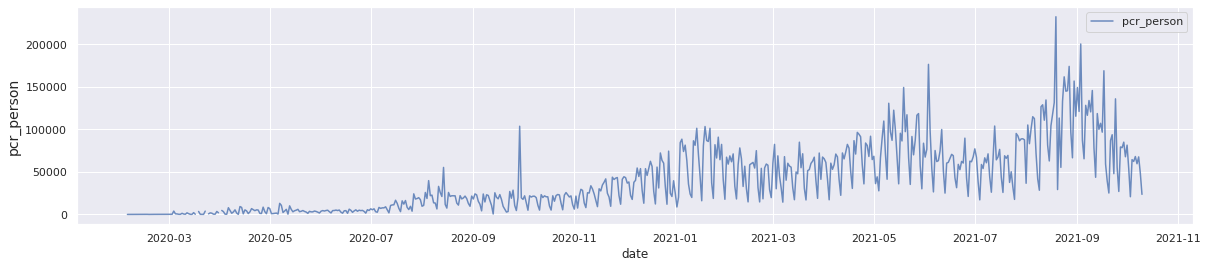

In [25]:
fig, axes = plt.subplots(figsize=(20, 4))
df3.groupby('date').agg({'pcr_person': 'mean'}).plot(ax=axes, label='date', alpha=0.8).set_ylabel('pcr_person', fontsize=14)
axes.legend()

・全国のPCR検査の実施件数

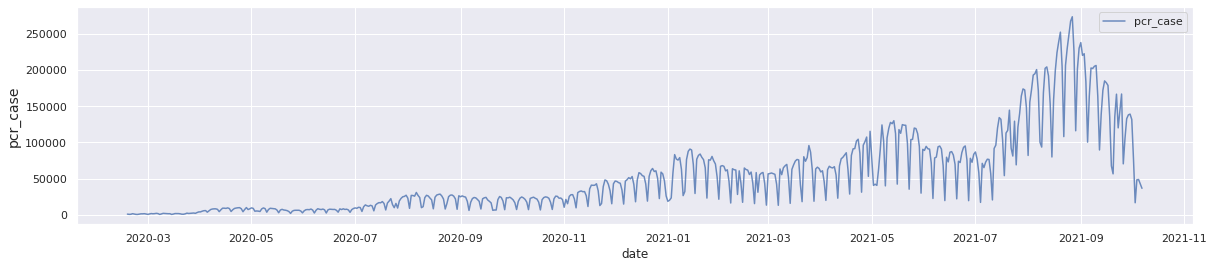

In [26]:
fig, axes = plt.subplots(figsize=(20, 4))
df4.groupby('date').agg({'pcr_case': 'mean'}).plot(ax=axes, label='date', alpha=0.8).set_ylabel('pcr_case', fontsize=14)
axes.legend()

# Datasets

・対象エリアを埼玉県に絞って、時系列解析を行う

In [27]:
df = df[df['prefecture'] == '埼玉県']
df.head()

,date,prefecture,infection_day,infection_sum,deaths_day,deaths_sum
6350,2020-01-16,埼玉県,0,0,0.0,0
6351,2020-01-17,埼玉県,0,0,0.0,0
6352,2020-01-18,埼玉県,0,0,0.0,0
6353,2020-01-19,埼玉県,0,0,0.0,0
6354,2020-01-20,埼玉県,0,0,0.0,0


In [28]:
df2 = df2[df2['prefecture'] == '埼玉県']
df2.head()

,date,prefecture,comparisonPreDay,comparisonPreDeclare,comparisonPreSpread
10,2021-10-10,埼玉県,-3.9,34.2,-11.2
57,2021-10-09,埼玉県,15.9,39.6,-7.6
104,2021-10-08,埼玉県,5.1,20.5,-9.3
151,2021-10-07,埼玉県,-1.7,14.7,-13.7
198,2021-10-06,埼玉県,-2.3,16.7,-12.2


In [29]:
saitama = pd.merge(df, df2, on='date', how='left')
saitama = saitama[~saitama.duplicated()]
saitama = saitama.drop(['prefecture_x', 'prefecture_y'], axis=1)

print(saitama.shape)
saitama[200:205]

(635, 8)


,date,infection_day,infection_sum,deaths_day,deaths_sum,comparisonPreDay,comparisonPreDeclare,comparisonPreSpread
281,2020-08-03,49,2507,0.0,74,5.7,13.7,-14.4
283,2020-08-04,49,2556,2.0,76,2.5,16.6,-12.2
285,2020-08-05,64,2620,1.0,77,-1.8,14.5,-13.8
287,2020-08-06,65,2685,2.0,79,1.5,16.2,-12.6
289,2020-08-07,50,2735,0.0,79,2.7,19.3,-10.2


In [30]:
saitama = pd.merge(saitama, df3, on='date', how='left')
saitama = pd.merge(saitama, df4, on='date', how='left')
saitama.head()

print(saitama.shape)
print(saitama.dtypes)
saitama[200:210]

(635, 10)
date                     object
infection_day             int64
infection_sum             int64
deaths_day              float64
deaths_sum                int64
comparisonPreDay        float64
comparisonPreDeclare    float64
comparisonPreSpread     float64
pcr_person              float64
pcr_case                float64
dtype: object


,date,infection_day,infection_sum,deaths_day,deaths_sum,comparisonPreDay,comparisonPreDeclare,comparisonPreSpread,pcr_person,pcr_case
200,2020-08-03,49,2507,0.0,74,5.7,13.7,-14.4,25794.0,26876.0
201,2020-08-04,49,2556,2.0,76,2.5,16.6,-12.2,18740.0,26715.0
202,2020-08-05,64,2620,1.0,77,-1.8,14.5,-13.8,39723.0,25804.0
203,2020-08-06,65,2685,2.0,79,1.5,16.2,-12.6,22015.0,30937.0
204,2020-08-07,50,2735,0.0,79,2.7,19.3,-10.2,22698.0,26864.0
205,2020-08-08,84,2819,0.0,79,-0.8,18.3,-21.7,13676.0,23921.0
206,2020-08-09,56,2875,0.0,79,-4.9,12.6,-25.5,13336.0,9932.0
207,2020-08-10,42,2917,0.0,79,-8.3,3.2,-31.7,6440.0,11290.0
208,2020-08-11,36,2953,0.0,79,11.2,14.8,-13.6,32939.0,23867.0
209,2020-08-12,45,2998,1.0,80,-2.5,11.8,-15.8,25782.0,27022.0


In [31]:
pd.DataFrame([['infection_day', '1日ごとの感染者数'],
              ['infection_sum', '累積感染者数'],
              ['deaths_day', '1日ごとの死亡者数'],
              ['deaths_sum', '累積死亡者数'],
              ['comparisonPreDay', '全国の人流増減率（対前日比）'],
              ['comparisonPreDeclare', '全国の人流増減率（対緊急事態宣言前比）'],
              ['comparisonPreSpread', '全国の人流増減率（対感染拡大前比）'],
              ['pcr_person', 'PCR検査の実施人数'],
              ['pcr_case', 'PCR検査の実施件数']],
              columns=['カラム', '意味'])

,カラム,意味
0,infection_day,1日ごとの感染者数
1,infection_sum,累積感染者数
2,deaths_day,1日ごとの死亡者数
3,deaths_sum,累積死亡者数
4,comparisonPreDay,全国の人流増減率（対前日比）
5,comparisonPreDeclare,全国の人流増減率（対緊急事態宣言前比）
6,comparisonPreSpread,全国の人流増減率（対感染拡大前比）
7,pcr_person,PCR検査の実施人数
8,pcr_case,PCR検査の実施件数


# Visualization

・対象エリアを埼玉県に絞って、可視化を行う

<AxesSubplot:>

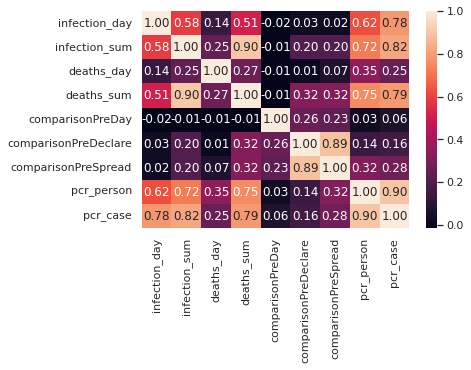

In [32]:
sns.heatmap(saitama.corr(), annot=True, fmt='.2f')

・埼玉県の1日ごとの感染者数

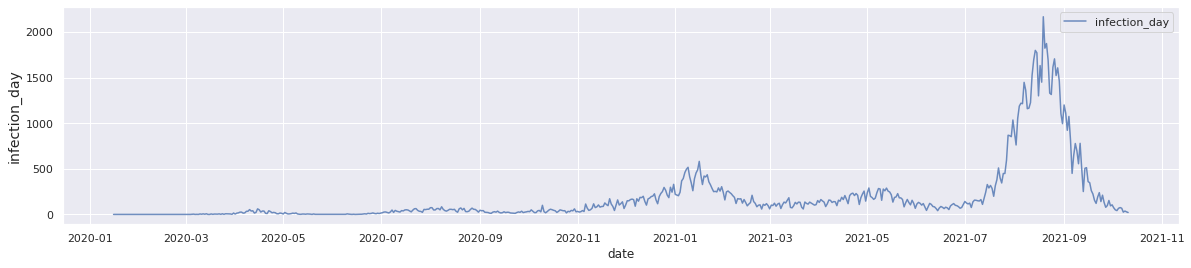

In [33]:
fig, axes = plt.subplots(figsize=(20, 4))
saitama.groupby('date').agg({'infection_day': 'sum'}).plot(ax=axes, label='date', alpha=0.8).set_ylabel('infection_day', fontsize=14)
axes.legend()

・埼玉県の累積感染者数

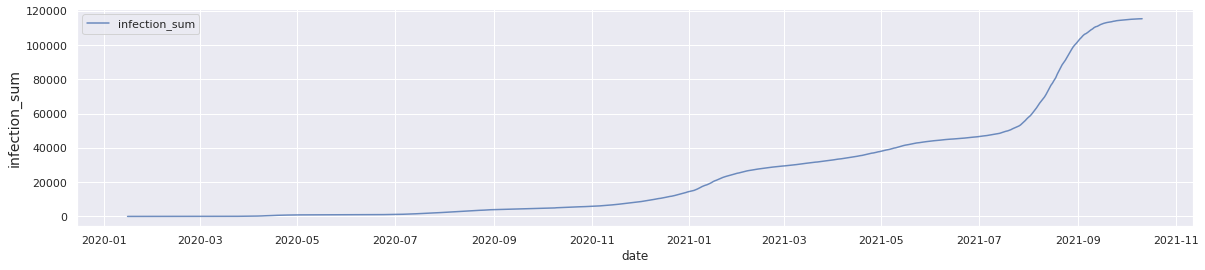

In [34]:
fig, axes = plt.subplots(figsize=(20, 4))
saitama.groupby('date').agg({'infection_sum': 'sum'}).plot(ax=axes, label='date', alpha=0.8).set_ylabel('infection_sum', fontsize=14)
axes.legend()

・埼玉県の1日ごとの死亡者数

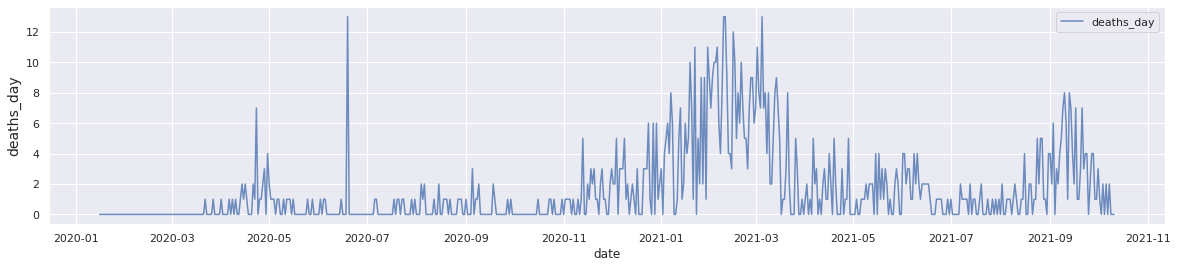

In [35]:
fig, axes = plt.subplots(figsize=(20, 4))
saitama.groupby('date').agg({'deaths_day': 'sum'}).plot(ax=axes, label='date', alpha=0.8).set_ylabel('deaths_day', fontsize=14)
axes.legend()

・埼玉県の累積死亡者数

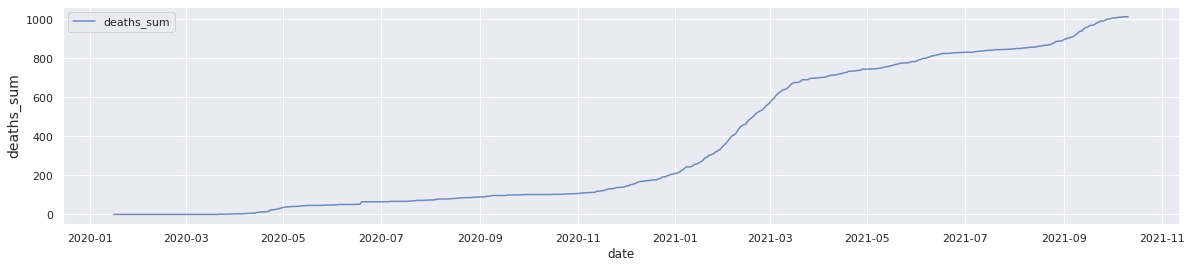

In [36]:
fig, axes = plt.subplots(figsize=(20, 4))
saitama.groupby('date').agg({'deaths_sum': 'sum'}).plot(ax=axes, label='date', alpha=0.8).set_ylabel('deaths_sum', fontsize=14)
axes.legend()

・埼玉の人流増減率（対前日比）

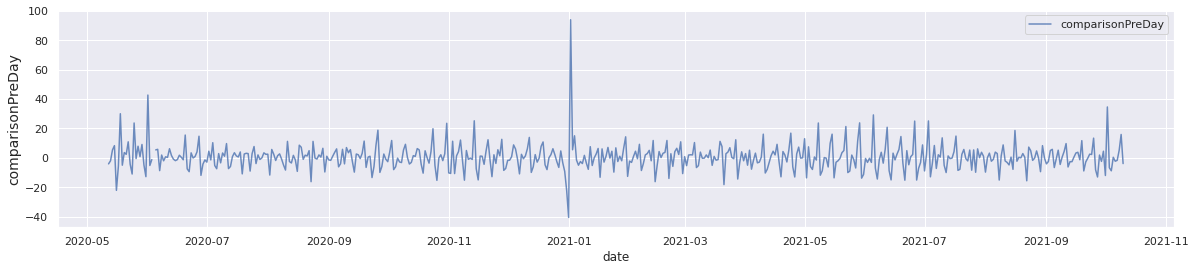

In [37]:
fig, axes = plt.subplots(figsize=(20, 4))
saitama.groupby('date').agg({'comparisonPreDay': 'mean'}).plot(ax=axes, label='date', alpha=0.8).set_ylabel('comparisonPreDay', fontsize=14)
axes.legend()

・埼玉の人流増減率（対緊急事態宣言前比）

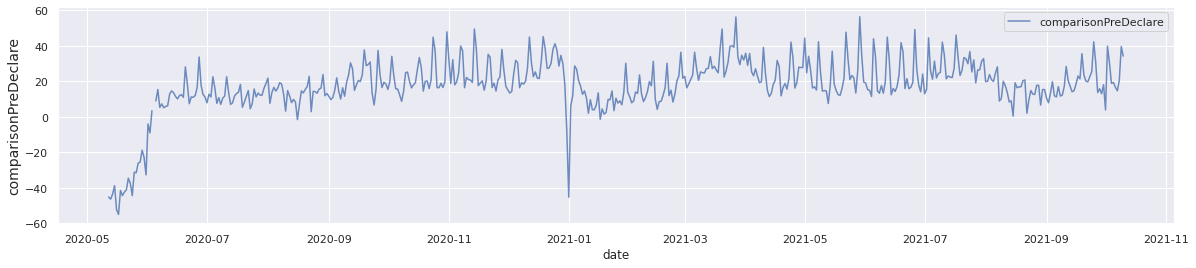

In [38]:
fig, axes = plt.subplots(figsize=(20, 4))
saitama.groupby('date').agg({'comparisonPreDeclare': 'mean'}).plot(ax=axes, label='date', alpha=0.8).set_ylabel('comparisonPreDeclare', fontsize=14)
axes.legend()

・埼玉の人流増減率（対感染拡大前比）

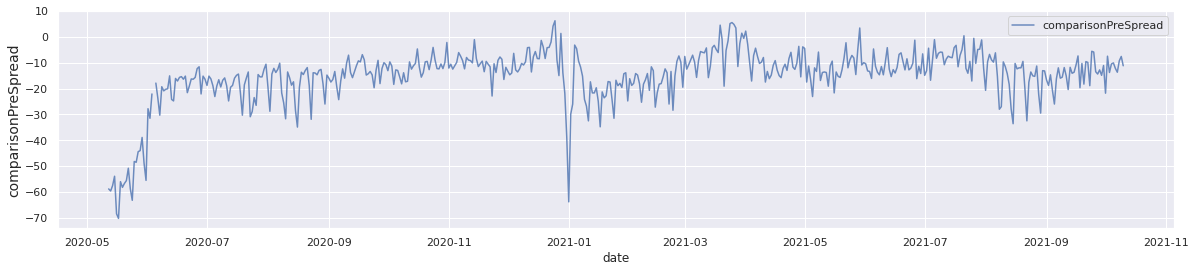

In [39]:
fig, axes = plt.subplots(figsize=(20, 4))
saitama.groupby('date').agg({'comparisonPreSpread': 'mean'}).plot(ax=axes, label='date', alpha=0.8).set_ylabel('comparisonPreSpread', fontsize=14)
axes.legend()

# ADF-test

・時系列解析を行う前に、定常性検定を行っておく

ADF Statistic: -3.377081
p-value: 0.011765
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569


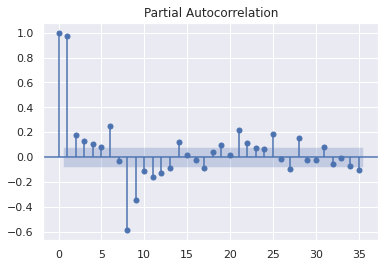

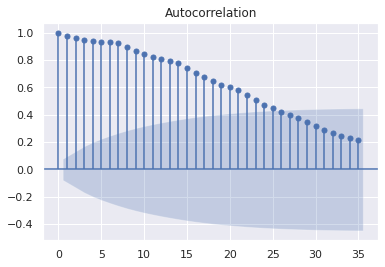

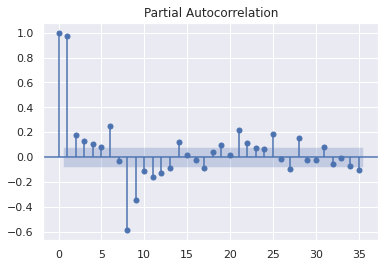

In [40]:
result = sm.tsa.stattools.adfuller(saitama['infection_day'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
sm.graphics.tsa.plot_acf(saitama['infection_day'], lags=35)
sm.graphics.tsa.plot_pacf(saitama['infection_day'], lags=35)

・p値が小さいので、データは定常性をもつことが示される<br>
・ADF統計値は、ほとんどの臨界値（Critical Value）より小さいので、定常性であると示唆される

・もし非定常性だった場合には、共和分（非定常性→定常性に変換する処理）を行う必要がある

# Preprocess

In [41]:
saitama = saitama.set_index('date')

print(saitama.shape)
saitama[200:210]

(635, 9)


,infection_day,infection_sum,deaths_day,deaths_sum,comparisonPreDay,comparisonPreDeclare,comparisonPreSpread,pcr_person,pcr_case
date,,,,,,,,,
2020-08-03,49,2507,0.0,74,5.7,13.7,-14.4,25794.0,26876.0
2020-08-04,49,2556,2.0,76,2.5,16.6,-12.2,18740.0,26715.0
2020-08-05,64,2620,1.0,77,-1.8,14.5,-13.8,39723.0,25804.0
2020-08-06,65,2685,2.0,79,1.5,16.2,-12.6,22015.0,30937.0
2020-08-07,50,2735,0.0,79,2.7,19.3,-10.2,22698.0,26864.0
2020-08-08,84,2819,0.0,79,-0.8,18.3,-21.7,13676.0,23921.0
2020-08-09,56,2875,0.0,79,-4.9,12.6,-25.5,13336.0,9932.0
2020-08-10,42,2917,0.0,79,-8.3,3.2,-31.7,6440.0,11290.0
2020-08-11,36,2953,0.0,79,11.2,14.8,-13.6,32939.0,23867.0


In [42]:
pd.DataFrame([['infection_day', '1日ごとの感染者数'],
              ['infection_sum', '累積感染者数'],
              ['deaths_day', '1日ごとの死亡者数'],
              ['deaths_sum', '累積死亡者数'],
              ['comparisonPreDay', '全国の人流増減率（対前日比）'],
              ['comparisonPreDeclare', '全国の人流増減率（対緊急事態宣言前比）'],
              ['comparisonPreSpread', '全国の人流増減率（対感染拡大前比）'],
              ['pcr_person', 'PCR検査の実施人数'],
              ['pcr_case', 'PCR検査の実施件数']],
              columns=['カラム', '意味'])

,カラム,意味
0,infection_day,1日ごとの感染者数
1,infection_sum,累積感染者数
2,deaths_day,1日ごとの死亡者数
3,deaths_sum,累積死亡者数
4,comparisonPreDay,全国の人流増減率（対前日比）
5,comparisonPreDeclare,全国の人流増減率（対緊急事態宣言前比）
6,comparisonPreSpread,全国の人流増減率（対感染拡大前比）
7,pcr_person,PCR検査の実施人数
8,pcr_case,PCR検査の実施件数


・時系列解析モデルを適用する際に、float型にしておく必要がある

In [43]:
saitama['infection_day'] = saitama['infection_day'].astype(float)

・学習データとテストデータに分割する

In [44]:
train_size = int(len(saitama) * 0.67)
test_size = len(saitama) - train_size

train = saitama.iloc[0:train_size, 0]
test = saitama.iloc[train_size:len(saitama), 0]

print(train.shape)
print(test.shape)

(425,)
(210,)


In [45]:
pd.DataFrame(train).tail()

,infection_day
date,
2021-03-11,126.0
2021-03-12,155.0
2021-03-13,183.0
2021-03-14,77.0
2021-03-15,72.0


In [46]:
pd.DataFrame(test).head()

,infection_day
date,
2021-03-16,96.0
2021-03-17,132.0
2021-03-18,115.0
2021-03-19,135.0
2021-03-20,133.0


In [47]:
pd.DataFrame([['学習データ', '2020/01/16～2021/03/15'],
              ['テストデータ', '2021/03/16～2021/10-11']],
              columns=['データ', '期間'])

,データ,期間
0,学習データ,2020/01/16～2021/03/15
1,テストデータ,2021/03/16～2021/10-11


# AR-model

・AR（自己回帰）モデル：時点tにおける出力が、時点t以前の出力に依存するモデル

In [48]:
ar = sm.tsa.AR(train)
print ('the order of arma is', ar.select_order(maxlag=6, ic='aic'))

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/ar_model.py:791: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning)
/opt/co

the order of arma is 6


In [49]:
pd.DataFrame([['学習データ', '2020/01/16～2021/03/15'],
              ['テストデータ', '2021/03/16～2021/10-11']],
              columns=['データ', '期間'])

,データ,期間
0,学習データ,2020/01/16～2021/03/15
1,テストデータ,2021/03/16～2021/10-11


In [50]:
ar = ARMA(train, order=(6, 0)).fit(dist=False)
train_prediction = ar.predict('2020-01-16', '2021-03-15')
test_prediction = ar.predict('2021-03-16', '2021-10-11')

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be use

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.73755D+00    |proj g|=  1.19833D-03

At iterate    5    f=  4.73754D+00    |proj g|=  2.50377D-04

At iterate   10    f=  4.73754D+00    |proj g|=  2.48690D-05

At iterate   15    f=  4.73754D+00    |proj g|=  2.95142D-04

At iterate   20    f=  4.73742D+00    |proj g|=  3.16165D-03

At iterate   25    f=  4.73702D+00    |proj g|=  1.24523D-04

At iterate   30    f=  4.73702D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


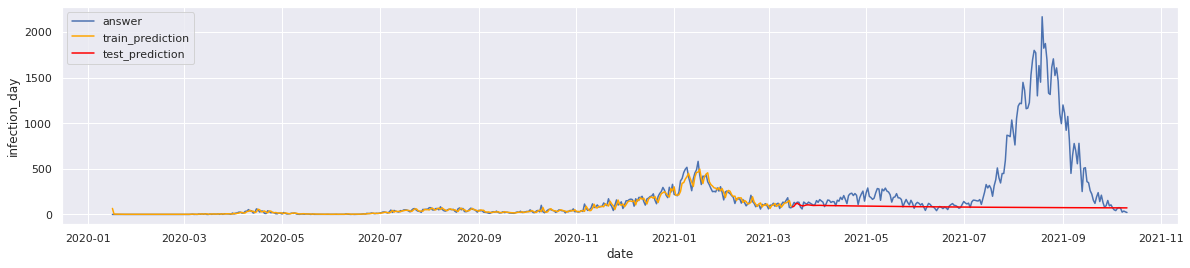

In [51]:
fig, axes = plt.subplots(figsize=(20, 4))
plt.plot(saitama['infection_day'], label='answer')
plt.plot(train_prediction, 'orange', label='train_prediction')
plt.plot(test_prediction, 'red', label='test_prediction')
plt.xlabel('date')
plt.ylabel('infection_day')
plt.legend()

# MA-model

・MA（移動平均）モデル：時点tにおける出力とホワイトノイズに依存するモデル

In [52]:
MA_order = sm.tsa.arma_order_select_ic(train, max_ar=0, max_ma=4, ic=['aic','bic'])
print ('order is', MA_order)

order is {'aic':              0            1            2            3            4
0  5147.880428  4714.392646  4511.307551  4382.487323  4287.727486, 'bic':              0            1            2            3            4
0  5155.984606  4726.548913  4527.515907  4402.747769  4312.040021, 'aic_min_order': (0, 4), 'bic_min_order': (0, 4)}


In [53]:
pd.DataFrame([['学習データ', '2020/01/16～2021/03/15'],
              ['テストデータ', '2021/03/16～2021/10-11']],
              columns=['データ', '期間'])

,データ,期間
0,学習データ,2020/01/16～2021/03/15
1,テストデータ,2021/03/16～2021/10-11


In [54]:
ma = sm.tsa.ARMA(train, order=(0, 4)).fit()
train_prediction = ma.predict('2020-01-16', '2021-03-15')
test_prediction = ma.predict('2021-03-16', '2021-10-11')

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be use

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.03052D+00    |proj g|=  8.64819D-04

At iterate    5    f=  5.03050D+00    |proj g|=  1.29852D-04

At iterate   10    f=  5.03049D+00    |proj g|=  7.10454D-04

At iterate   15    f=  5.03031D+00    |proj g|=  2.67306D-03

At iterate   20    f=  5.03027D+00    |proj g|=  9.05942D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     30      1     0     0   0.000D+00   5.030D+00
  F =   5.0302676301407896     

CONVERG

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


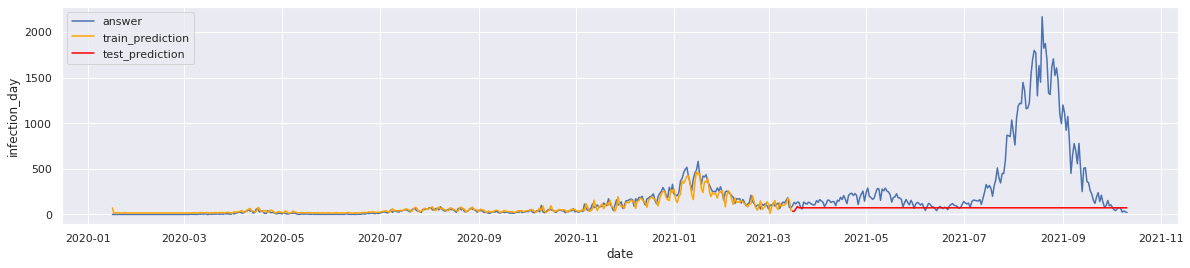

In [55]:
fig, axes = plt.subplots(figsize=(20, 4))
plt.plot(saitama['infection_day'], label='answer')
plt.plot(train_prediction, 'orange', label='train_prediction')
plt.plot(test_prediction, 'red', label='test_prediction')
plt.xlabel('date')
plt.ylabel('infection_day')
plt.legend()

# ARMA-model

・ARMA（自己回帰移動平均）モデル：ARモデルとMAモデルの2手法を融合したモデル

In [56]:
ARMA_order = sm.tsa.arma_order_select_ic(train, max_ar=4, max_ma=4, ic=['aic','bic'])
print ('order is', ARMA_order)

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


order is {'aic':              0            1            2            3            4
0  5147.880428  4714.392646  4511.307551  4382.487323  4287.727486
1  4096.552027  4087.775885  4069.951238  4064.093638  4063.828845
2  4090.602348  4066.705725  4066.512298  4065.756915  4050.300239
3  4088.176537  4065.079507  4040.404581  4019.661173  4032.483978
4  4079.671294  4056.349610          NaN  4032.839418  3994.057561, 'bic':              0            1            2            3            4
0  5155.984606  4726.548913  4527.515907  4402.747769  4312.040021
1  4108.708294  4103.984241  4090.211684  4088.406173  4092.193469
2  4106.810704  4086.966171  4090.824833  4094.121539  4082.716952
3  4108.436983  4089.392042  4068.769205  4052.077887  4068.952781
4  4103.983829  4084.714234          NaN  4069.308220  4034.578452, 'aic_min_order': (4, 4), 'bic_min_order': (4, 4)}


In [57]:
pd.DataFrame([['学習データ', '2020/01/16～2021/03/15'],
              ['テストデータ', '2021/03/16～2021/10-11']],
              columns=['データ', '期間'])

,データ,期間
0,学習データ,2020/01/16～2021/03/15
1,テストデータ,2021/03/16～2021/10-11


In [58]:
arma = sm.tsa.ARMA(train, order=(4, 4)).fit()
train_prediction = arma.predict('2020-01-16', '2021-03-15')
test_prediction = arma.predict('2021-03-16', '2021-10-11')

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be use

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.67923D+00    |proj g|=  9.24549D-03

At iterate    5    f=  4.67913D+00    |proj g|=  1.05321D-02

At iterate   10    f=  4.67860D+00    |proj g|=  9.09157D-03

At iterate   15    f=  4.67814D+00    |proj g|=  1.08983D-02

At iterate   20    f=  4.67800D+00    |proj g|=  9.78284D-03

At iterate   25    f=  4.67759D+00    |proj g|=  2.55050D-02

At iterate   30    f=  4.67742D+00    |proj g|=  2.75546D-02

At iterate   35    f=  4.67641D+00    |proj g|=  3.27833D-02

At iterate   40    f=  4.67616D+00    |proj g|=  1.34921D-02

At iterate   45    f=  4.67600D+00    |proj g|=  1.84743D-02

At iterate   50    f=  4.67590D+00    |proj g|=  1.00807D-02

At iterate   55    f=  4.67581D+00    |proj g|=  6.00116D-03

At iterate   60    f=  4.67577D+00    |proj g|=  1.32117D-03

At iterate   65    f=  4.6

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


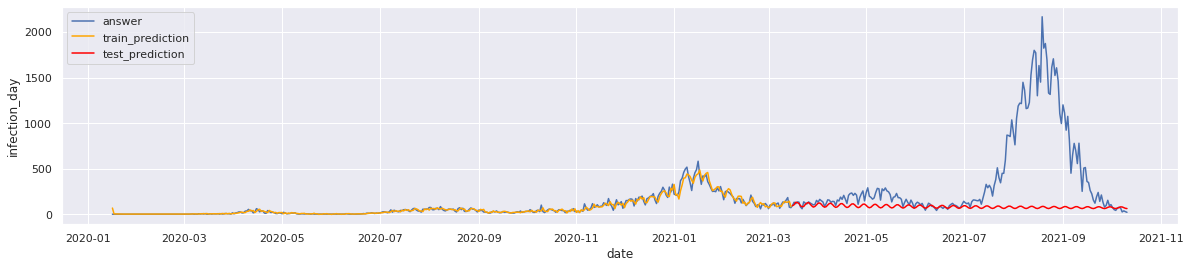

In [59]:
fig, axes = plt.subplots(figsize=(20, 4))
plt.plot(saitama['infection_day'], label='answer')
plt.plot(train_prediction, 'orange', label='train_prediction')
plt.plot(test_prediction, 'red', label='test_prediction')
plt.xlabel('date')
plt.ylabel('infection_day')
plt.legend()

# ARIMA-model

・ARIMA（自己回帰和分移動平均）モデル：共和分のような処理を行った後に、ARMAモデルを実行するモデル

In [60]:
for i in range(2):
    diff = np.diff(train, n=i)
    resdiff = sm.tsa.arma_order_select_ic(diff, ic='aic', trend='nc')
    print(resdiff)

{'aic':              0            1            2
0          NaN  4851.712311  4622.733249
1  4097.948275  4088.019186  4069.124878
2  4091.248946  4065.829283  4065.624178
3  4088.420596  4064.181889  4039.766885
4  4079.440513  4055.395677  4019.188138, 'aic_min_order': (4, 2)}


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


{'aic':              0            1            2
0          NaN  4077.907577  4056.667988
1  4082.093345  4053.325629  4053.068621
2  4078.309229  4051.589510  4027.642011
3  4068.268448  4042.693181  4008.015058
4  4038.506761  4029.514718  3997.542150, 'aic_min_order': (4, 2)}


In [61]:
pd.DataFrame([['学習データ', '2020/01/16～2021/03/15'],
              ['テストデータ', '2021/03/16～2021/10-11']],
              columns=['データ', '期間'])

,データ,期間
0,学習データ,2020/01/16～2021/03/15
1,テストデータ,2021/03/16～2021/10-11


In [62]:
arima = ARIMA(train, order=(4, 2, 1)).fit(dist=False)
train_prediction = arima.predict('2020-01-18', '2021-03-15')
test_prediction = arima.predict('2021-03-16', '2021-10-11')

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be use

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.76039D+00    |proj g|=  1.37996D-01

At iterate    5    f=  4.76024D+00    |proj g|=  4.13545D-03

At iterate   10    f=  4.76024D+00    |proj g|=  4.28457D-04

At iterate   15    f=  4.76024D+00    |proj g|=  3.12639D-05

At iterate   20    f=  4.76024D+00    |proj g|=  1.37579D-04

At iterate   25    f=  4.76024D+00    |proj g|=  3.55271D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     33      1     0     0   

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


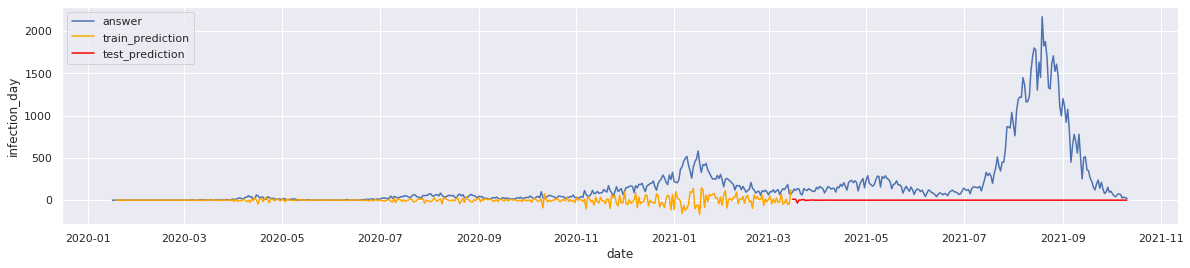

In [63]:
fig, axes = plt.subplots(figsize=(20, 4))
plt.plot(saitama['infection_day'], label='answer')
plt.plot(train_prediction, 'orange', label='train_prediction')
plt.plot(test_prediction, 'red', label='test_prediction')
plt.xlabel('date')
plt.ylabel('infection_day')
plt.legend()

# SARIMA-model

・SARIMA（季節性自己回帰和分移動平均）モデル：季節的な周期変動を捉えつつ、ARIMAモデルを実行するモデル

In [64]:
max_p = 3
max_q = 3
max_d = 2
max_sp = 1
max_sq = 1
max_sd = 1

pattern = max_p*(max_d + 1)*(max_q + 1)*(max_sp + 1)*(max_sq + 1)*(max_sd + 1)

In [65]:
modelselection = pd.DataFrame(np.nan, index=range(pattern), columns=["model", "aic"])
print(modelselection.shape)

(288, 2)


In [66]:
'''
num = 0

for p in range(1, max_p + 1):
    for d in range(0, max_d + 1):
        for q in range(0, max_q + 1):
            for sp in range(0, max_sp + 1):
                for sd in range(0, max_sd + 1):
                    for sq in range(0, max_sq + 1):
                        sarima = sm.tsa.SARIMAX(train,
                                                order=(p, d, q),
                                                seasonal_order=(sp, sd, sq, 12),
                                                enforce_stationarity = False,
                                                enforce_invertibility = False).fit()
                        
                        modelselection.iloc[num, 0] = 'order=(' + str(p) + ',' + str(d) + ',' + str(q) + '), season=(' + str(sp) + ',' + str(sd) + ',' + str(sq) + ')'
                        modelselection.iloc[num, 1] = sarima.aic
                        num = num + 1
                        
modelselection.sort_values(by='aic').head()
'''

"\nnum = 0\n\nfor p in range(1, max_p + 1):\n    for d in range(0, max_d + 1):\n        for q in range(0, max_q + 1):\n            for sp in range(0, max_sp + 1):\n                for sd in range(0, max_sd + 1):\n                    for sq in range(0, max_sq + 1):\n                        sarima = sm.tsa.SARIMAX(train,\n                                                order=(p, d, q),\n                                                seasonal_order=(sp, sd, sq, 12),\n                                                enforce_stationarity = False,\n                                                enforce_invertibility = False).fit()\n                        \n                        modelselection.iloc[num, 0] = 'order=(' + str(p) + ',' + str(d) + ',' + str(q) + '), season=(' + str(sp) + ',' + str(sd) + ',' + str(sq) + ')'\n                        modelselection.iloc[num, 1] = sarima.aic\n                        num = num + 1\n                        \nmodelselection.sort_values(by='aic').hea

In [67]:
pd.DataFrame([['学習データ', '2020/01/16～2021/03/15'],
              ['テストデータ', '2021/03/16～2021/10-11']],
              columns=['データ', '期間'])

,データ,期間
0,学習データ,2020/01/16～2021/03/15
1,テストデータ,2021/03/16～2021/10-11


In [68]:
sarima = sm.tsa.SARIMAX(train, order=(2,1,3), seasonal_order=(0,1,1,12)).fit()
train_prediction = arima.predict('2020-01-18', '2021-03-15')
test_prediction = arima.predict('2021-03-16', '2021-10-11')

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.98876D+00    |proj g|=  2.24479D+00

At iterate    5    f=  4.72542D+00    |proj g|=  8.51497D-02

At iterate   10    f=  4.70677D+00    |proj g|=  4.80792D-02

At iterate   15    f=  4.66298D+00    |proj g|=  1.26869D-01

At iterate   20    f=  4.62453D+00    |proj g|=  1.33938D-01

At iterate   25    f=  4.62209D+00    |proj g|=  2.96713D-02

At iterate   30    f=  4.61024D+00    |proj g|=  2.86082D-01

At iterate   35    f=  4.60683D+00    |proj g|=  1.05985D-02

At iterate   40    f=  4.60683D+00    |proj g|=  9.68538D-04

At iterate   45    f=  4.60681D+00    |proj g|=  9.64032D-03

At iterate   50    f=  4.60679D+00    |proj g|=  5.26243D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


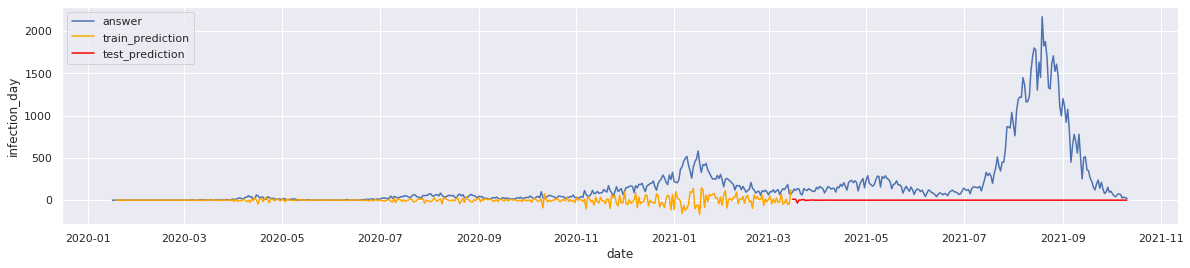

In [69]:
fig, axes = plt.subplots(figsize=(20, 4))
plt.plot(saitama['infection_day'], label='answer')
plt.plot(train_prediction, 'orange', label='train_prediction')
plt.plot(test_prediction, 'red', label='test_prediction')
plt.xlabel('date')
plt.ylabel('infection_day')
plt.legend()

・統計的な時系列解析モデルでは、1つの特徴量しか使用できないため、未知のデータには上手く対応できないということが考えられる

# LightGBM

・埼玉県のコロナウイルス感染者数を、機械学習モデル（LightGBM）で予測する

In [70]:
saitama = saitama.drop(['infection_sum', 'deaths_sum'], axis=1)
saitama[200:210]

,infection_day,deaths_day,comparisonPreDay,comparisonPreDeclare,comparisonPreSpread,pcr_person,pcr_case
date,,,,,,,
2020-08-03,49.0,0.0,5.7,13.7,-14.4,25794.0,26876.0
2020-08-04,49.0,2.0,2.5,16.6,-12.2,18740.0,26715.0
2020-08-05,64.0,1.0,-1.8,14.5,-13.8,39723.0,25804.0
2020-08-06,65.0,2.0,1.5,16.2,-12.6,22015.0,30937.0
2020-08-07,50.0,0.0,2.7,19.3,-10.2,22698.0,26864.0
2020-08-08,84.0,0.0,-0.8,18.3,-21.7,13676.0,23921.0
2020-08-09,56.0,0.0,-4.9,12.6,-25.5,13336.0,9932.0
2020-08-10,42.0,0.0,-8.3,3.2,-31.7,6440.0,11290.0
2020-08-11,36.0,0.0,11.2,14.8,-13.6,32939.0,23867.0


In [71]:
pd.DataFrame([['infection_day', '1日ごとの感染者数'],
              ['infection_sum', '累積感染者数'],
              ['deaths_day', '1日ごとの死亡者数'],
              ['deaths_sum', '累積死亡者数'],
              ['comparisonPreDay', '全国の人流増減率（対前日比）'],
              ['comparisonPreDeclare', '全国の人流増減率（対緊急事態宣言前比）'],
              ['comparisonPreSpread', '全国の人流増減率（対感染拡大前比）'],
              ['pcr_person', 'PCR検査の実施人数'],
              ['pcr_case', 'PCR検査の実施件数']],
              columns=['カラム', '意味'])

,カラム,意味
0,infection_day,1日ごとの感染者数
1,infection_sum,累積感染者数
2,deaths_day,1日ごとの死亡者数
3,deaths_sum,累積死亡者数
4,comparisonPreDay,全国の人流増減率（対前日比）
5,comparisonPreDeclare,全国の人流増減率（対緊急事態宣言前比）
6,comparisonPreSpread,全国の人流増減率（対感染拡大前比）
7,pcr_person,PCR検査の実施人数
8,pcr_case,PCR検査の実施件数


In [72]:
train = saitama[:train_size]
test = saitama[train_size:]

In [73]:
X_train = train[[col for col in train.columns if col != 'infection_day']]
y_train = train['infection_day']

print(X_train.shape)
X_train[200:205]

(425, 6)


,deaths_day,comparisonPreDay,comparisonPreDeclare,comparisonPreSpread,pcr_person,pcr_case
date,,,,,,
2020-08-03,0.0,5.7,13.7,-14.4,25794.0,26876.0
2020-08-04,2.0,2.5,16.6,-12.2,18740.0,26715.0
2020-08-05,1.0,-1.8,14.5,-13.8,39723.0,25804.0
2020-08-06,2.0,1.5,16.2,-12.6,22015.0,30937.0
2020-08-07,0.0,2.7,19.3,-10.2,22698.0,26864.0


In [74]:
X_test = test[[col for col in test.columns if col != 'infection_day']]
y_test = test['infection_day']

print(X_test.shape)
X_test.head()

(210, 6)


,deaths_day,comparisonPreDay,comparisonPreDeclare,comparisonPreSpread,pcr_person,pcr_case
date,,,,,,
2021-03-16,5.0,1.0,28.5,-3.3,47776.0,69081.0
2021-03-17,0.0,-1.6,26.4,-4.9,84919.0,74284.0
2021-03-18,1.0,-1.2,24.8,-6.1,54899.0,76547.0
2021-03-19,1.0,11.2,38.8,4.5,71301.0,75859.0
2021-03-20,3.0,7.7,49.5,-1.1,30658.0,41569.0


In [75]:
pd.DataFrame([['学習データ', '2020/01/16～2021/03/15'],
              ['テストデータ', '2021/03/16～2021/10-11']],
              columns=['データ', '期間'])

,データ,期間
0,学習データ,2020/01/16～2021/03/15
1,テストデータ,2021/03/16～2021/10-11


In [76]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.23, random_state=666)

In [77]:
'''
def create_model(trial):
    num_leaves = trial.suggest_int('num_leaves', 2, 30)
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 0.99)
    max_depth = trial.suggest_int('max_depth', 2, 10)
    min_child_samples = trial.suggest_int('min_child_samples', 100, 1200)
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 5, 90)
    bagging_freq = trial.suggest_int('bagging_freq', 1, 7)
    bagging_fraction = trial.suggest_uniform('bagging_fraction', 0.0001, 1.0)
    feature_fraction = trial.suggest_uniform('feature_fraction', 0.0001, 1.0)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    
    model = lgb.LGBMRegressor(
        num_leaves=num_leaves,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth, 
        min_child_samples=min_child_samples, 
        min_data_in_leaf=min_data_in_leaf,
        bagging_freq=bagging_freq,
        bagging_fraction=bagging_fraction,
        feature_fraction=feature_fraction,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=666)
    return model

def objective(trial):
    model = create_model(trial)
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_pred, y_val))
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=40)
params = study.best_params
print(params)'''

"\ndef create_model(trial):\n    num_leaves = trial.suggest_int('num_leaves', 2, 30)\n    n_estimators = trial.suggest_int('n_estimators', 50, 300)\n    learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 0.99)\n    max_depth = trial.suggest_int('max_depth', 2, 10)\n    min_child_samples = trial.suggest_int('min_child_samples', 100, 1200)\n    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 5, 90)\n    bagging_freq = trial.suggest_int('bagging_freq', 1, 7)\n    bagging_fraction = trial.suggest_uniform('bagging_fraction', 0.0001, 1.0)\n    feature_fraction = trial.suggest_uniform('feature_fraction', 0.0001, 1.0)\n    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)\n    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)\n    \n    model = lgb.LGBMRegressor(\n        num_leaves=num_leaves,\n        n_estimators=n_estimators,\n        learning_rate=learning_rate,\n        max_depth=max_depth, \n        min_child_samples=min_child_samples, \n

In [78]:
params = {'num_leaves': 22,
          'n_estimators': 247,
          'learning_rate': 0.6193190587049365,
          'max_depth': 2,
          'min_child_samples': 1197,
          'min_data_in_leaf': 10,
          'bagging_freq': 5,
          'bagging_fraction': 0.8478650397034109,
          'feature_fraction': 0.9960658630981004,
          'subsample': 0.5879739344264698,
          'colsample_bytree': 0.32742903237789817,
          'random_state': 666}

In [79]:
cls = lgb.LGBMRegressor(**params)
cls.fit(X_train, y_train)
y_pred = cls.predict(X_test)

[LightGBM] [Warning] bagging_fraction is set=0.8478650397034109, subsample=0.5879739344264698 will be ignored. Current value: bagging_fraction=0.8478650397034109
[LightGBM] [Warning] feature_fraction is set=0.9960658630981004, colsample_bytree=0.32742903237789817 will be ignored. Current value: feature_fraction=0.9960658630981004
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=1197 will be ignored. Current value: min_data_in_leaf=10


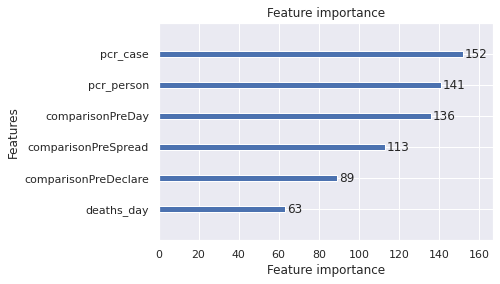

In [80]:
lgb.plot_importance(cls)
plt.show()

In [81]:
X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)
y_pred = cls.predict(X)

In [82]:
data = pd.DataFrame(y)
data = data.rename(columns={'infection_day': 'answer'})
data['prediction'] = y_pred

In [83]:
train_prediction = data.iloc[:train_size, 1]
test_prediction = data.iloc[train_size:, 1]

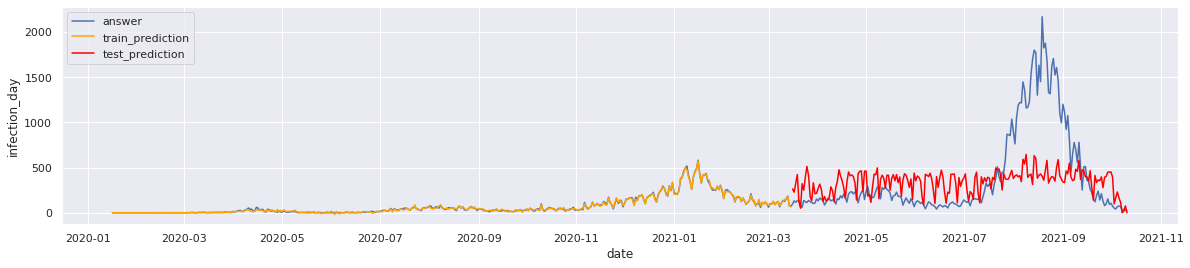

In [84]:
fig, axes = plt.subplots(figsize=(20, 4))
plt.plot(saitama['infection_day'], label='answer')
plt.plot(train_prediction, 'orange', label='train_prediction')
plt.plot(test_prediction, 'red', label='test_prediction')
plt.xlabel('date')
plt.ylabel('infection_day')
plt.legend()

・機械学習（勾配ブースティング）による時系列解析では、多変数の時系列解析に特化していないため、正確な予測を行えていない可能性が高い

# LSTM

・埼玉県のコロナウイルス感染者数を、深層学習モデル（LSTM）で予測する

In [85]:
print(saitama.shape)
saitama[200:210]

(635, 7)


,infection_day,deaths_day,comparisonPreDay,comparisonPreDeclare,comparisonPreSpread,pcr_person,pcr_case
date,,,,,,,
2020-08-03,49.0,0.0,5.7,13.7,-14.4,25794.0,26876.0
2020-08-04,49.0,2.0,2.5,16.6,-12.2,18740.0,26715.0
2020-08-05,64.0,1.0,-1.8,14.5,-13.8,39723.0,25804.0
2020-08-06,65.0,2.0,1.5,16.2,-12.6,22015.0,30937.0
2020-08-07,50.0,0.0,2.7,19.3,-10.2,22698.0,26864.0
2020-08-08,84.0,0.0,-0.8,18.3,-21.7,13676.0,23921.0
2020-08-09,56.0,0.0,-4.9,12.6,-25.5,13336.0,9932.0
2020-08-10,42.0,0.0,-8.3,3.2,-31.7,6440.0,11290.0
2020-08-11,36.0,0.0,11.2,14.8,-13.6,32939.0,23867.0


In [86]:
pd.DataFrame([['infection_day', '1日ごとの感染者数'],
              ['infection_sum', '累積感染者数'],
              ['deaths_day', '1日ごとの死亡者数'],
              ['deaths_sum', '累積死亡者数'],
              ['comparisonPreDay', '全国の人流増減率（対前日比）'],
              ['comparisonPreDeclare', '全国の人流増減率（対緊急事態宣言前比）'],
              ['comparisonPreSpread', '全国の人流増減率（対感染拡大前比）'],
              ['pcr_person', 'PCR検査の実施人数'],
              ['pcr_case', 'PCR検査の実施件数']],
              columns=['カラム', '意味'])

,カラム,意味
0,infection_day,1日ごとの感染者数
1,infection_sum,累積感染者数
2,deaths_day,1日ごとの死亡者数
3,deaths_sum,累積死亡者数
4,comparisonPreDay,全国の人流増減率（対前日比）
5,comparisonPreDeclare,全国の人流増減率（対緊急事態宣言前比）
6,comparisonPreSpread,全国の人流増減率（対感染拡大前比）
7,pcr_person,PCR検査の実施人数
8,pcr_case,PCR検査の実施件数


In [87]:
saitama = saitama.values
saitama = saitama.astype(float)

In [88]:
train_size = int(len(saitama) * 0.67)
test_size = len(saitama) - train_size
train, test = saitama[0:train_size,:], saitama[train_size:len(saitama),:]

print(train_size)
print(test_size)

425
210


In [89]:
pd.DataFrame([['学習データ', '2020/01/16～2021/03/15'],
              ['テストデータ', '2021/03/16～2021/10-11']],
              columns=['データ', '期間'])

,データ,期間
0,学習データ,2020/01/16～2021/03/15
1,テストデータ,2021/03/16～2021/10-11


In [90]:
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [91]:
look_back = 6

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(418, 6)
(418,)
(203, 6)
(203,)


In [92]:
model = Sequential()
model.add(Dense(12, input_dim=look_back, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, batch_size=2, verbose=2)

2021-10-26 08:02:23.813772: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-26 08:02:23.818256: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-10-26 08:02:23.818297: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-26 08:02:23.818347: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (b4fcf48fbe38): /proc/driver/nvidia/version does not exist
2021-10-26 08:02:23.820171: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Epoch 1/50
209/209 - 1s - loss: 2375.5339
Epoch 2/50
209/209 - 0s - loss: 1112.6763
Epoch 3/50
209/209 - 0s - loss: 1024.6820
Epoch 4/50
209/209 - 0s - loss: 1025.1588
Epoch 5/50
209/209 - 0s - loss: 958.6409
Epoch 6/50
209/209 - 0s - loss: 895.8862
Epoch 7/50
209/209 - 0s - loss: 882.8111
Epoch 8/50
209/209 - 0s - loss: 900.8472
Epoch 9/50
209/209 - 0s - loss: 863.2653
Epoch 10/50
209/209 - 0s - loss: 845.9009
Epoch 11/50
209/209 - 0s - loss: 846.9727
Epoch 12/50
209/209 - 0s - loss: 884.1133
Epoch 13/50
209/209 - 0s - loss: 821.7012
Epoch 14/50
209/209 - 0s - loss: 838.0734
Epoch 15/50
209/209 - 0s - loss: 875.3420
Epoch 16/50
209/209 - 0s - loss: 804.1646
Epoch 17/50
209/209 - 0s - loss: 811.1955
Epoch 18/50
209/209 - 0s - loss: 815.4432
Epoch 19/50
209/209 - 0s - loss: 829.5605
Epoch 20/50
209/209 - 0s - loss: 853.7534
Epoch 21/50
209/209 - 0s - loss: 803.0770
Epoch 22/50
209/209 - 0s - loss: 817.5677
Epoch 23/50
209/209 - 0s - loss: 859.6076
Epoch 24/50
209/209 - 0s - loss: 726.10

In [93]:
train_prediction = model.predict(trainX)
test_prediction = model.predict(testX)

In [94]:
data_train = pd.DataFrame(trainY, columns=['trainY'])
data_train['prediction'] = train_prediction
data_train['date'] = np.arange(0, 418)
data_train = data_train.set_index('date')

In [95]:
data_test = pd.DataFrame(testY, columns=['trainY'])
data_test['prediction'] = test_prediction
data_test['date'] = np.arange(418, 621)
data_test= data_test.set_index('date')

In [96]:
data = pd.concat([data_train, data_test], axis=0)

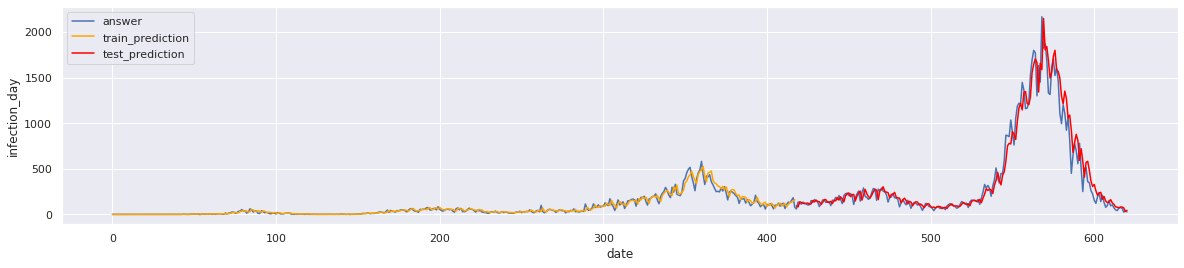

In [97]:
fig, axes = plt.subplots(figsize=(20, 4))
plt.plot(data['trainY'], label='answer')
plt.plot(data_train['prediction'], 'orange', label='train_prediction')
plt.plot(data_test['prediction'], 'red', label='test_prediction')
plt.xlabel('date')
plt.ylabel('infection_day')
plt.legend()

・深層学習による時系列解析は、多変数の時系列解析に特化しているということから、上記のようにある程度正確な予測が行えていると考えられる

# Conclusion

・時系列解析を行う際には、まずLSTMでモデリングしてみることが望ましい